In [1]:
import cv2
import numpy as np
import glob
import os
import cv2

import matplotlib.pyplot as plt

from comb_registration import keypoints_match_image, get_upper_keypoints
from comb_registration import load_reference_mask
from comb_registration import load_reference_image
from comb_registration import load_reference_keypoints
from comb_registration import show_keypoints_on_image
from comb_registration import load_keypoints
from comb_registration import get_warp_matrix

In [2]:
image_rescale_factor = .15

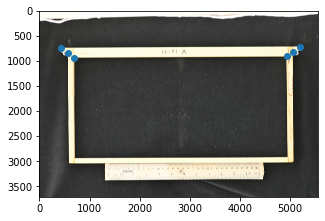

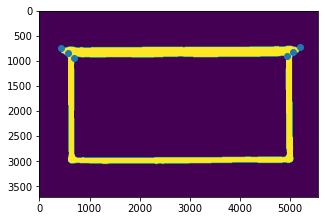

In [4]:
root_folder = "/home/golden/kenya_drones/comb-detection/nest_photos"

reference_image = load_reference_image(root_folder)
reference_mask = load_reference_mask(root_folder, resize=True)
reference_keypoints = load_reference_keypoints(root_folder, resize=True, 
                                               return_upper=True
                                              )

show_keypoints_on_image(reference_image, reference_keypoints)
show_keypoints_on_image(reference_mask, reference_keypoints)

### Get images, masks and keypoints for alignment

In [5]:
# Just warp images or masks too
use_mask = True

image_root = "/home/golden/kenya_drones/comb-detection/nest_photos"
image_files = sorted(glob.glob(os.path.join(image_root, "*", "*", "DSC_0110.[jJ][pP][gG]")))
print(f"{len(image_files)} images found.")

mask_folder = "masks"


keypoint_files = []
if use_mask:
    mask_files = []
for image_file in image_files:
    name = os.path.splitext(os.path.basename(image_file))[0]
    keypoint_folder = os.path.join(os.path.dirname(image_file), 'keypoints')
    keypoint_files.append(os.path.join(keypoint_folder, name + '.csv'))
    if use_mask:
        masks_folder = os.path.join(os.path.dirname(image_file), mask_folder)
        mask_files.append(os.path.join(masks_folder, name + '.png'))
print(f"{len(keypoint_files)} keypoint files found.")
print(f"{len(mask_files)} mask files found.")

1 images found.
1 keypoint files found.
1 mask files found.


### Visualize specific image alignment

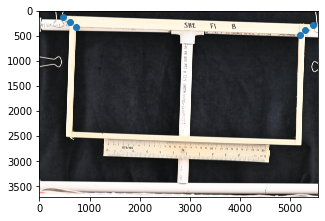

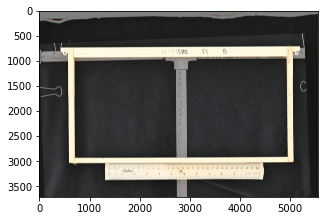

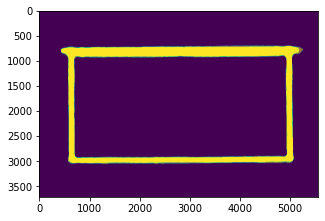

In [6]:
frame_ind = 0

use_mask = True

image_file = image_files[frame_ind]
image = plt.imread(image_file)
if use_mask:
    mask_file = mask_files[frame_ind]
keypoints_file = keypoint_files[frame_ind]
keypoints_match_image(keypoints_file, image_file)
keypoints = load_keypoints(keypoints_file, resize=True, return_upper=True)

transform = get_warp_matrix(keypoints, reference_keypoints)
warped_image = cv2.warpAffine(image, M=transform, 
                              dsize=(reference_image.shape[1], reference_image.shape[0])
                             )

show_keypoints_on_image(image, keypoints)

plt.figure(figsize=(5, 5))
plt.imshow(reference_image)
plt.imshow(warped_image, alpha=0.5)

if use_mask:
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, None, fx=(1/image_rescale_factor), 
                      fy=(1/image_rescale_factor), interpolation=cv2.INTER_AREA
                     )
    warped_mask = cv2.warpAffine(mask, M=transform, 
                                 dsize=(reference_image.shape[1], reference_image.shape[0])
                                 )


    plt.figure(figsize=(5, 5))
    plt.imshow((reference_mask).astype(int), vmin=0, vmax=int(warped_mask.max()))
    plt.imshow((warped_mask).astype(int), alpha=0.5, vmin=0, vmax=int(warped_mask.max()))

In [ ]:
num_keypoints = len(keypoint_files)


save = False
custom_save_folder = False # "/home/golden/kenya_drones/comb-detection/annotations/random_warped_images"
if custom_save_folder:
    os.makedirs(custom_save_folder, exist_ok=True)
plot = True

use_mask = True

# inds = np.random.randint(0, len(keypoint_files), 100)
inds = [0]

for ind in inds:
    image_file = image_files[ind]
    keypoints_file = keypoint_files[ind]

    if use_mask:
        mask_file = mask_files[ind]
    keypoints = np.genfromtxt(keypoints_file, delimiter=',')
    keypoints = get_upper_keypoints(keypoints) / image_rescale_factor
    
    image = cv2.imread(image_file)
    if custom_save_folder:
        warped_image_file = os.path.join(custom_save_folder,
                                         os.path.basename(image_file)
                                        )
    else:
        warped_image_file = image_file.replace("images", 
                                        "images_warped"
                                       )
    if use_mask:
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        if custom_save_folder:
            warped_mask_file = os.path.join(custom_mask_folder, 
                                            "masks", 
                                            os.path.basename(mask_file)
                                           )
        else:
            warped_mask_file = mask_file.replace("masks_all_classes", 
                                            "masks_all_classes_warped"
                                           )
    
    
    warp = True
    for name in frames_to_not_warp:
        if name in image_file:
            warp = False
    if not warp:
        print("not warping")
        # Don't warp just resize and save
        image = cv2.resize(image,
              (reference_image.shape[1], reference_image.shape[0]),
              interpolation=cv2.INTER_AREA
             )
        warped_image = image[500:,300:-300]
        if use_mask:
            mask = cv2.resize(mask,
                  (reference_image.shape[1], reference_image.shape[0]),
                  interpolation=cv2.INTER_LINEAR
                 )
            warped_mask = mask[500:,300:-300]
            
    else:

        
        transform, inliers = cv2.estimateAffinePartial2D(keypoints, 
                                                         reference_keypoints, 
                                                         ransacReprojThreshold=50,
                                                         confidence=.98
                                                        )
        if np.sum(inliers) <= 4:
            print(np.sum(inliers))

        warped_image = cv2.warpAffine(image, M=transform, 
                                      dsize=(reference_image.shape[1], reference_image.shape[0])
                                      )
        warped_image = warped_image[500:,300:-300]
        if use_mask:
            warped_mask = cv2.warpAffine(mask, M=transform, 
                                          dsize=(reference_image.shape[1], reference_image.shape[0])
                                         )
            warped_mask = warped_mask[500:,300:-300]
    
        if np.sum(inliers) <= 3:
            print(f"{ind}: {np.sum(inliers)} inliers")
    
    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(warped_image[...,::-1])
        plt.title(str(ind) + warped_image_file)
        if use_mask:
            plt.figure(figsize=(10,10))
            plt.imshow(warped_mask, alpha=1.0)
            plt.title(str(ind) + warped_mask_file)

       
    if save:
        os.makedirs(os.path.dirname(warped_image_file), exist_ok=True)
        cv2.imwrite(warped_image_file, warped_image)
        if use_mask:
            os.makedirs(os.path.dirname(warped_mask_file), exist_ok=True)
            
            cv2.imwrite(warped_mask_file, warped_mask)
        
    if ind % 10 == 0:
        print(f"{ind} images processed")

In [4]:
# root = '/home/golden/kenya_drones/comb-detection/annotations'

# mask_files = os.path.join(root, "masks_all_classes", "P*.png")
# mask_files = sorted(glob.glob(mask_files))

# mask_files_warped = os.path.join(root, "masks_all_classes_warped", "*.png")
# mask_files_warped = sorted(glob.glob(mask_files_warped))

In [6]:


# root = '/home/golden/kenya_drones/comb-detection/annotations'

# mask_files = os.path.join(root, "masks_all_classes", "*.png")
# mask_files = sorted(glob.glob(mask_files))

# images_folder = os.path.join(root, 'images')
# keypoint_folder = os.path.join(root, 'images', 'keypoints')

# image_files = []
# keypoint_files = []

# for mask_file in mask_files:
#     name = os.path.splitext(os.path.basename(mask_file))[0]
#     image_files.append(os.path.join(images_folder, name + '.jpg'))
#     keypoint_files.append(os.path.join(keypoint_folder, name + '.csv'))
    

# keypoint_files = sorted(glob.glob(os.path.join(image_root, "*", "*", 
#                                                "keypoints", "*.csv"))
#                        )

# print(f"{len(keypoint_files)} keypoints found.")
# mask_files = sorted(glob.glob(os.path.join(image_root, "*", "*", 
#                                                "masks", "*.png"))
#                        )


# # print(f"{len(mask_files)} masks found.")


print(f"{len(image_files)} images,",
      f"{len(keypoint_files)} keypoint files"
     )
if use_masks:
    print(f"{len(mask_files)} masks.")

1 images found.
1 images, 1 keypoint files


## Draw keypoints on reference frame

[[ 573.33333333  840.        ]
 [ 686.66666667  933.33333333]
 [5206.66666667  713.33333333]
 [5066.66666667  820.        ]
 [4946.66666667  906.66666667]
 [ 433.33333333  740.        ]]


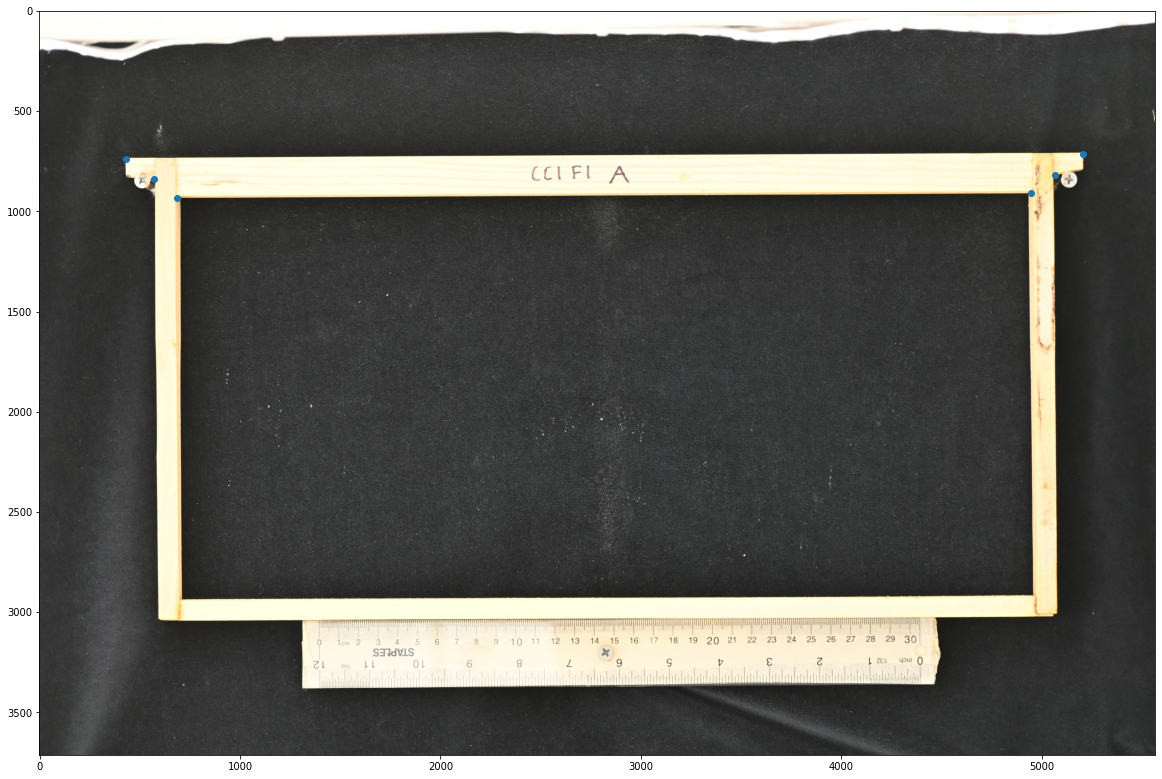

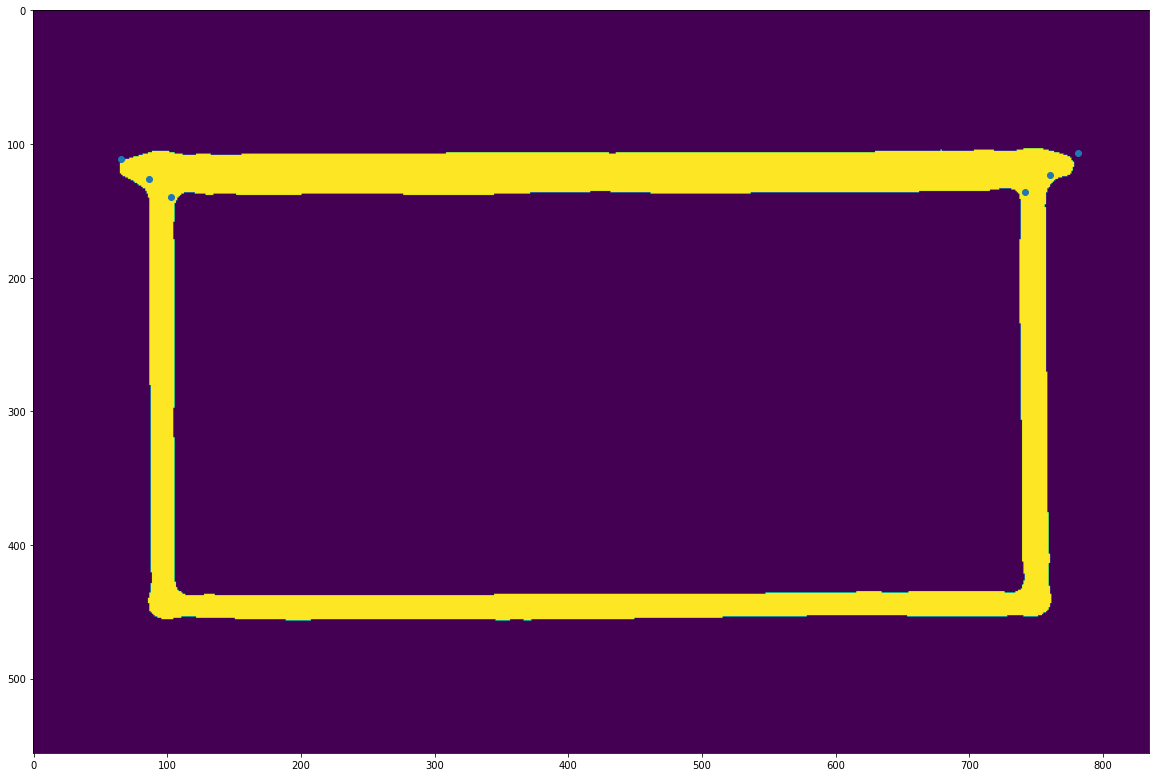

In [11]:
for ind, f in enumerate(keypoint_files):
    if "DSC_1001" in f:
        print(ind)

## Warp specific frame (number frame_ind) to reference frame

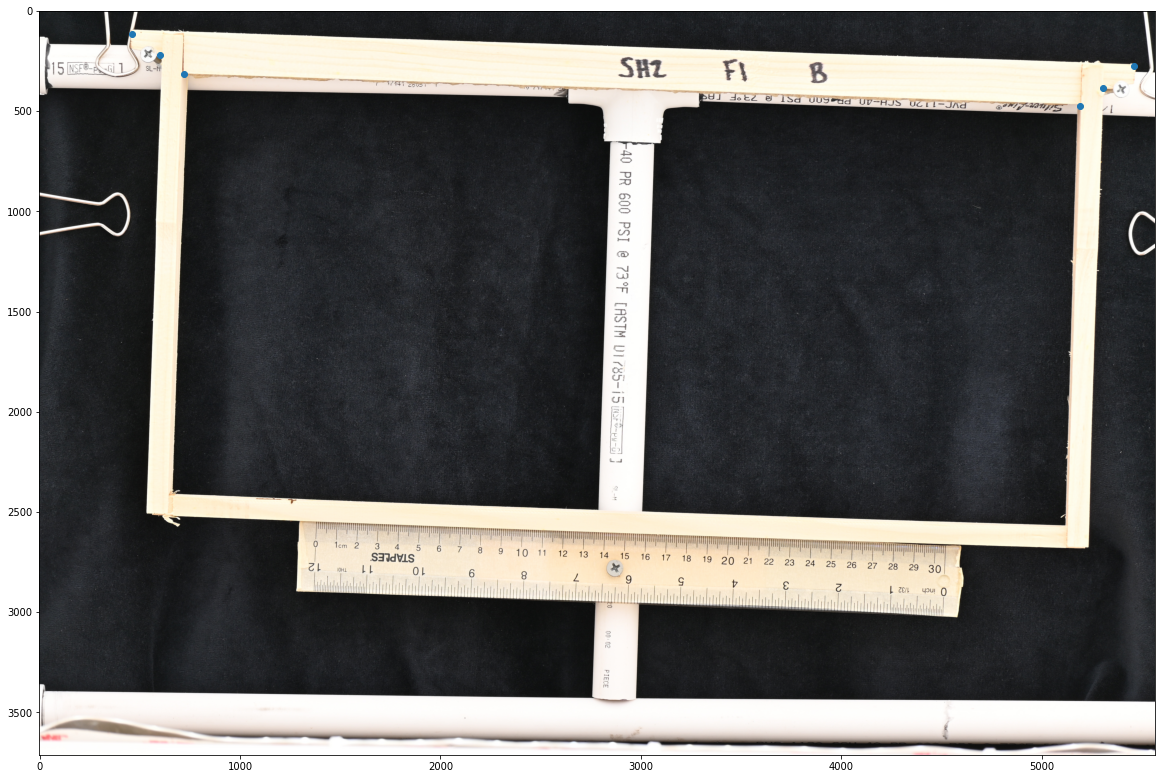

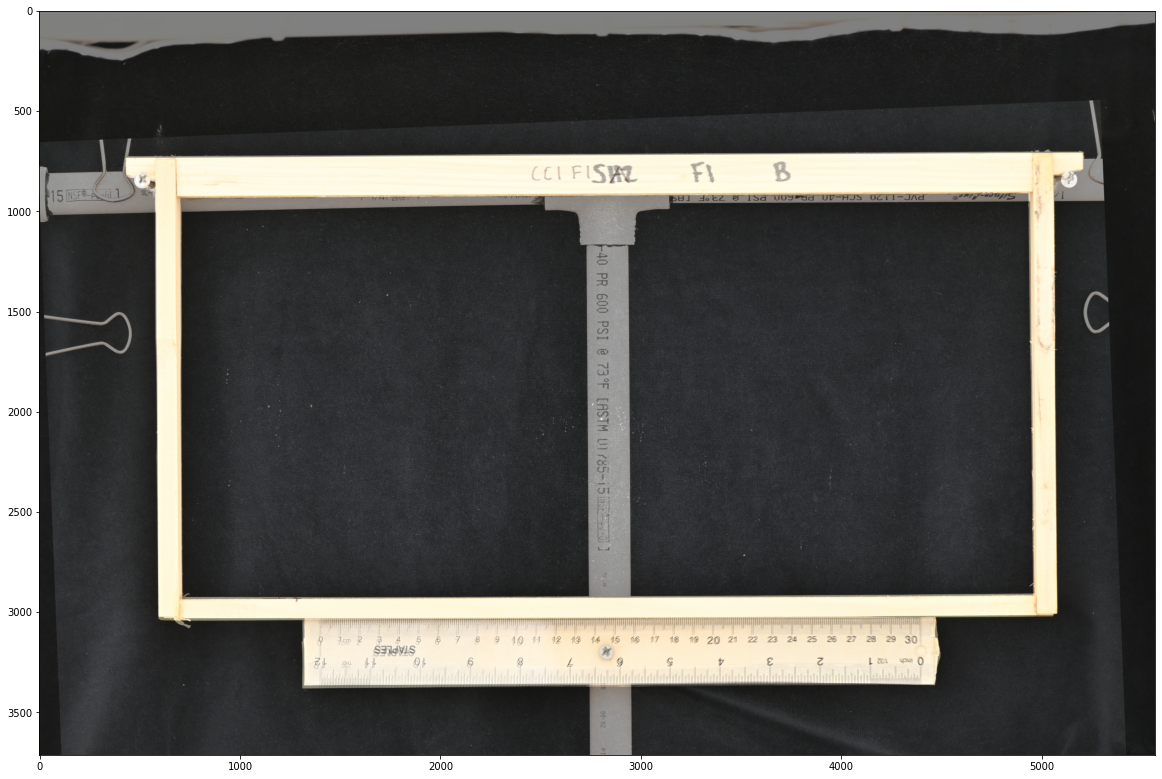

array([1544, 3049, 3029, 3463, 1021,  889,  492, 3030, 2097, 4065])

## Warp all frame masks to reference frame mask and save results

In [69]:
os.path.dirname(warped_image_file)

NameError: name 'warped_image_file' is not defined

In [22]:
mask_files = ["/home/golden/kenya_drones/comb-detection/annotations/masks_all_classes_warped/DSC_0110.png"]

In [19]:
mask = cv2.imread(masks_files[0], cv2.IMREAD_GRAYSCALE)
im = plt.imread(image_files[0])

In [21]:
image_files[0]

'/home/golden/kenya_drones/comb-detection/nest_photos/SH2/20210412/DSC_0110.JPG'

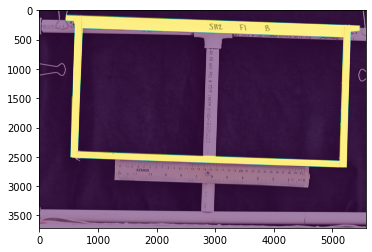

In [20]:
plt.imshow(im)
plt.imshow(mask, alpha=.5)

0 images processed


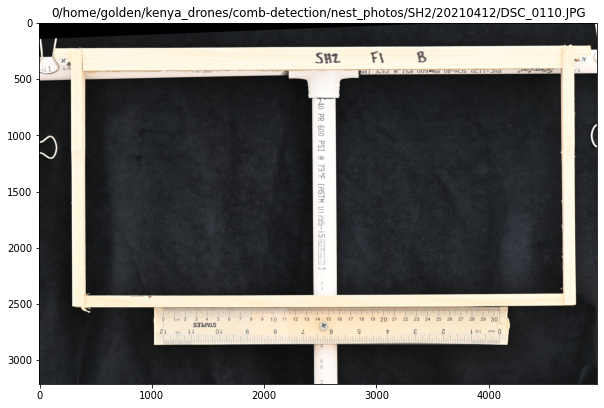

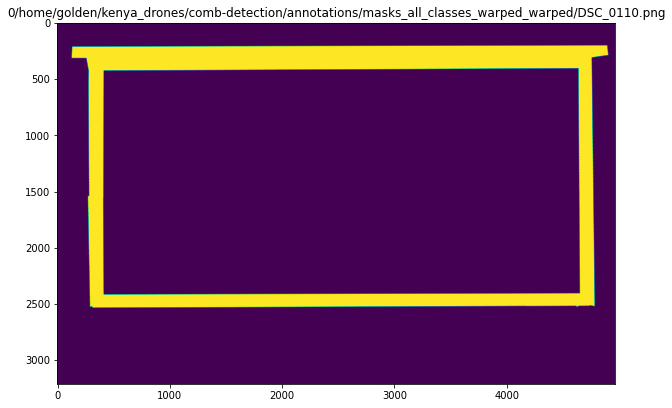

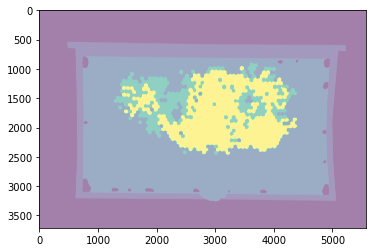

In [112]:
# plt.imshow(plt.imread("/home/golden/kenya_drones/comb-detection/annotations/images_warped/DSC_8335.jpg"))

plt.imshow(plt.imread("/home/golden/kenya_drones/comb-detection/annotations/masks_all_classes/DSC_8335.png"),
          alpha=.5)


In [102]:
len(mask_files[:-6])

126

## Copy with no warps

In [108]:
num_keypoints = len(keypoint_files)

save = True

inds = [23, 82, 93, 101, 108, 109, 110, 111, 112, 113]

for ind in inds: 
    
    keypoints_file = keypoint_files[ind]
    print(mask_files[ind])
    mask_file = mask_files[ind]
    image_file = image_files[ind]
    
    keypoints = np.genfromtxt(keypoints_file, delimiter=',')
    keypoints = get_upper_keypoints(keypoints) / image_rescale_factor
    
    warped_mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
#     warped_mask = warped_mask[500:,300:-300]
    warped_image = cv2.imread(image_file)
#     warped_image = warped_image[500:,300:-300]

    # was "masks" and "warped_masks"
    warped_mask_file = mask_file.replace("masks_all_classes", 
                                    "masks_all_classes_warped"
                                   )
    warped_image_file = image_file.replace("images", 
                                    "images_warped"
                                   )

        
    if save:
        os.makedirs(os.path.dirname(warped_image_file), exist_ok=True)
        cv2.imwrite(warped_image_file, warped_image)

        os.makedirs(os.path.dirname(warped_mask_file), exist_ok=True)
        cv2.imwrite(warped_mask_file, warped_mask)

/home/golden/kenya_drones/comb-detection/annotations/masks_all_classes/3.png
/home/golden/kenya_drones/comb-detection/annotations/masks_all_classes/DSC_1137.png
/home/golden/kenya_drones/comb-detection/annotations/masks_all_classes/DSC_2272.png
/home/golden/kenya_drones/comb-detection/annotations/masks_all_classes/DSC_2784.png
/home/golden/kenya_drones/comb-detection/annotations/masks_all_classes/DSC_8289.png
/home/golden/kenya_drones/comb-detection/annotations/masks_all_classes/DSC_8294.png
/home/golden/kenya_drones/comb-detection/annotations/masks_all_classes/DSC_8295.png
/home/golden/kenya_drones/comb-detection/annotations/masks_all_classes/DSC_8298.png
/home/golden/kenya_drones/comb-detection/annotations/masks_all_classes/DSC_8302.png
/home/golden/kenya_drones/comb-detection/annotations/masks_all_classes/DSC_8304.png


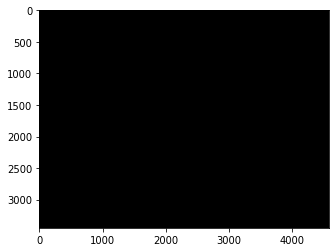

In [85]:
plt.imshow(warped_mask)

In [86]:
warped_mask.max()

0.0